From tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from methods import *
from utils import *

# Choice of Model to Attack
- LeNet5: MNIST
- Basic CNN: Fashion MNIST
- ResNet20: CIFAR-10
### Run **ONE** of the following 3 cells

In [2]:
from models.LeNet import *
target_mdl = LeNet("models/lenet_mnist_model.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader
mdl_name='MNIST'

In [3]:
from models.simple_FashionMNIST import *
target_mdl = simple_FashionMNIST("models/simple_FashionMNIST.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader
mdl_name = 'FMNIST'

Running on cpu.
Model weights loaded successfully


In [4]:
from models.resNet import ResNet20
target_mdl = ResNet20()
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader
mdl_name = 'ResNet'

Using cache found in C:\Users\JIC/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [37]:
hist_dfs = []
final_hist_dfs = []
hist = None

debug = True
targeted = True
epsilon = 0.01
ex_savers = []
# Run test for each epsilon
#algs = ['fw', 'fw_away', 'fw_pair']
algs = ['fw']
fw_stepsize_rule = 'amjo'
#algs = ['fw_away']
#for alg in algs:
alg = 'fw'
rules = ['decay', 'amjo', 'ls']
for step_rule in rules:
    fw_stepsize_rule = step_rule
    ex_saver = example_saver()
    acc, ex, hist = test(target_mdl, device,
                         epsilon = epsilon, 
                         num_fw_iter = 20,
                         method = alg, 
                         early_stopping = 'gap_FW', 
                         fw_stepsize_rule = fw_stepsize_rule, 
                         gap_FW_tol = 1E-1,
                         targeted = targeted, 
                         num_test = 100, 
                         ex_saver=ex_saver,
                         norm_p=-1, # -1 for infnty norm
                         seed=11)
    ex_savers.append(ex_saver)
    hist_dfs.append(hist)
    final_hist = hist.groupby('example_idx').tail(1)
    final_hist_dfs.append(final_hist) # hist with just the rows of last FW iters
final_hist_dfs[-1]

  1%|          | 109/10000 [00:15<23:54,  6.90it/s]


Epsilon: 0.01	Correct Classifications (Failed Attacks) = 5 / 100 = 0.05


  1%|          | 109/10000 [00:29<45:18,  3.64it/s] 


Epsilon: 0.01	Correct Classifications (Failed Attacks) = 4 / 100 = 0.04


  1%|          | 109/10000 [03:07<4:42:54,  1.72s/it]

Epsilon: 0.01	Correct Classifications (Failed Attacks) = 4 / 100 = 0.04


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,adv_target,stepsize,l_inf,mdlLoss,targeted_success
5,0,6,0.042425,True,False,9,8,gap,8,0.08,0.010000,0.015220,True
18,1,13,0.076381,True,False,6,8,gap,8,0.10,0.010000,0.163259,True
30,2,12,0.076517,True,False,0,8,gap,8,0.08,0.010000,0.035685,True
34,3,4,0.041108,True,False,1,9,gap,9,0.14,0.008382,0.010004,True
36,4,2,0.072562,True,False,7,3,gap,3,0.26,0.010000,0.007361,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,95,3,0.000215,True,False,6,3,gap,3,0.24,0.010000,0.000035,True
777,96,6,0.090435,True,False,8,7,gap,7,0.14,0.009367,0.028919,True
790,97,13,0.071975,True,False,1,5,gap,5,0.18,0.009990,0.066244,True
797,98,7,0.087121,True,False,7,0,gap,0,0.18,0.010000,0.047052,True


6
5
4


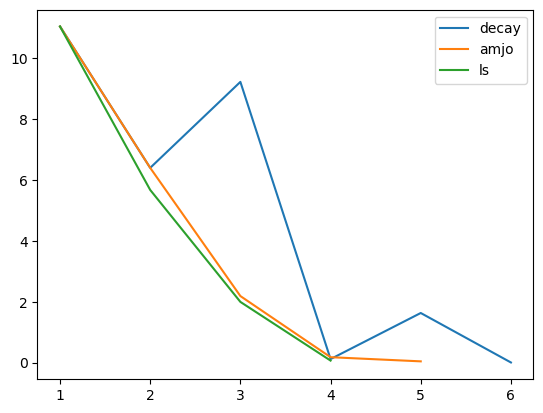

In [40]:
ex_idx = 5
for i, df in enumerate(hist_dfs):
    single_ex = df[df['example_idx'] == ex_idx]
    print(len(single_ex))
    plt.plot(single_ex['FW_iter'], single_ex['gap_FW'], label=rules[i])

plt.legend()

decay
	Targeted Attack Success Rate: 0.95
	Avg iters: 8.03
amjo
	Targeted Attack Success Rate: 0.96
	Avg iters: 7.97
ls
	Targeted Attack Success Rate: 0.96
	Avg iters: 8.01


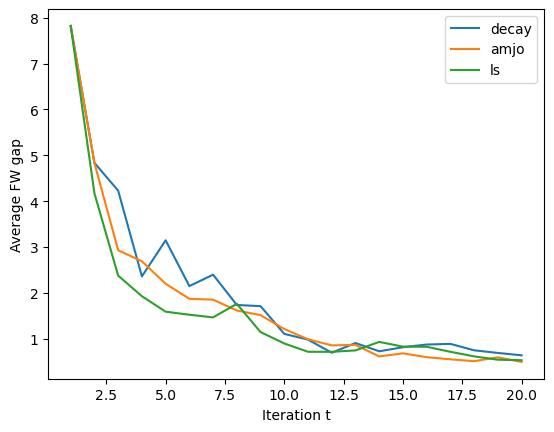

In [39]:
plot_convergence(hist_dfs, rules)

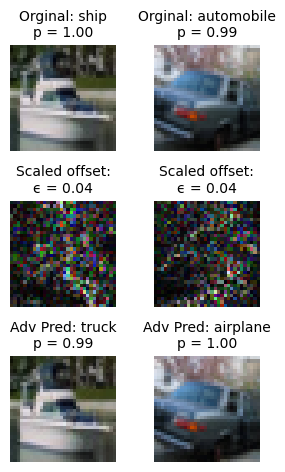

In [48]:
display_examples(ex_savers[0], epsilon, target_mdl.classes, show_atk_mag=True, n_col=2, offset=0)

Stepsize Choice Analysis

decay
	Targeted Attack Success Rate: 0.63
	Avg iters: 13.26
amjo
	Targeted Attack Success Rate: 0.66
	Avg iters: 12.94
ls
	Targeted Attack Success Rate: 0.63
	Avg iters: 12.81


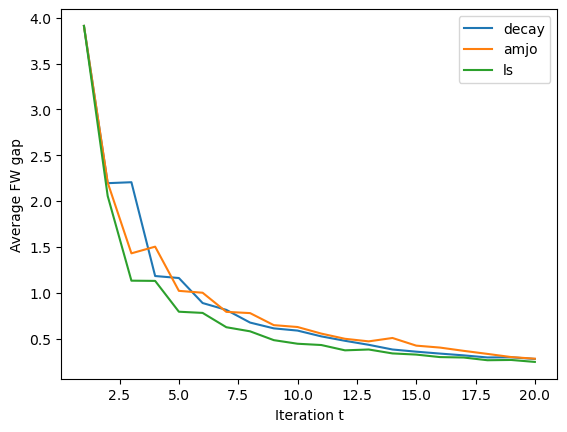

In [7]:
# gamma = 0.5
# delta = 0.5
# 'fw'
# 100 examples CIFAR10 eps = 0.005 targeted
plot_convergence(hist_dfs, step_rules)

decay
	Targeted Attack Success Rate: 0.62
	Avg iters: 13.33
amjo
	Targeted Attack Success Rate: 0.64
	Avg iters: 13.04
ls
	Targeted Attack Success Rate: 0.63
	Avg iters: 12.87


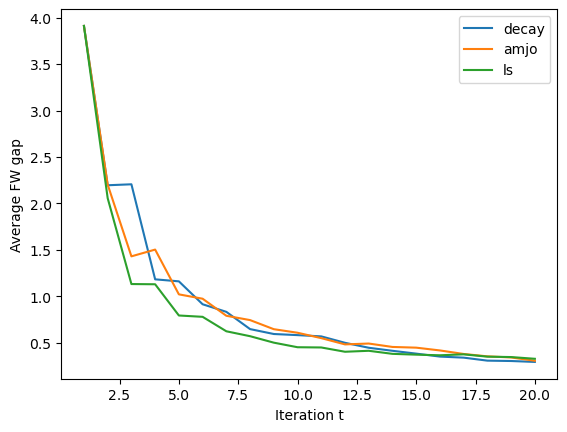

In [7]:
# gamma = 0.5
# delta = 0.5
# 'fw_away'
# 100 examples CIFAR10 eps = 0.005 targeted
plot_convergence(hist_dfs, step_rules)

decay
	Targeted Attack Success Rate: 0.62
	Avg iters: 13.96
amjo
	Targeted Attack Success Rate: 0.62
	Avg iters: 13.46
ls
	Targeted Attack Success Rate: 0.61
	Avg iters: 13.5


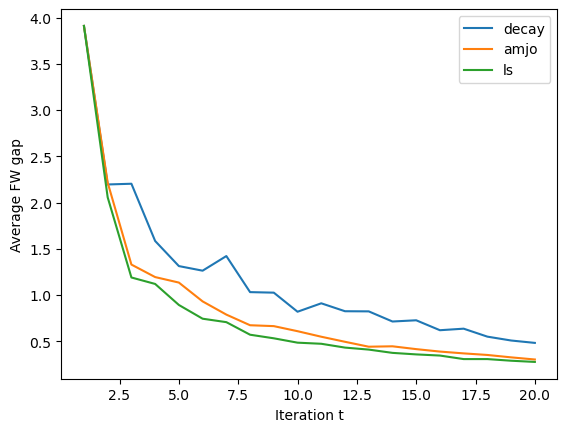

In [14]:
# gamma = 0.5
# delta = 0.5
# 'fw_pair'
# 100 examples CIFAR10 eps = 0.005 targeted
plot_convergence(hist_dfs, step_rules)

decay
	Targeted Attack Success Rate: 0.654
	Avg iters: 12.78
ls
	Targeted Attack Success Rate: 0.65
	Avg iters: 12.336
amjo
	Targeted Attack Success Rate: 0.664
	Avg iters: 12.776


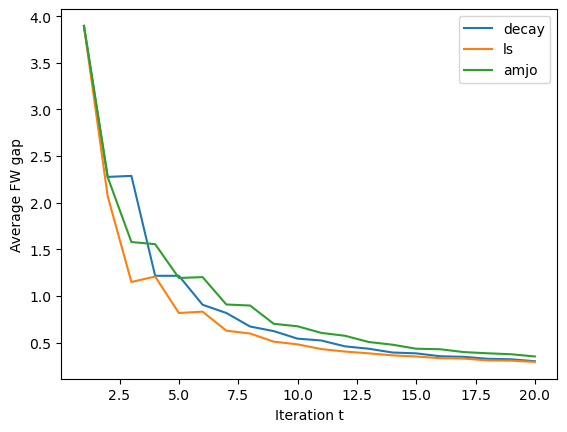

In [35]:
dfs = []
rules = ['decay', 'ls', 'amjo']
for rule in rules:
    df = pd.read_csv(f"Report/Results/hist_{rule}.tsv", sep='\t')
    dfs.append(df)
rule_hist = pd.concat(dfs)
plot_convergence(dfs,rules)

In [34]:
[hist.groupby('example_idx').tail(1) for hist in rule_hist]

AttributeError: 'str' object has no attribute 'groupby'

In [32]:
hist

,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,adv_target,stepsize,l_inf,mdlLoss,targeted_success,rule
0,0,1,2.548006,False,False,9,9,None,8,1.00,0.005,15.079809,False,ls
1,0,2,1.322431,False,False,9,9,None,8,0.46,0.005,6.906051,False,ls
2,0,3,0.757083,False,False,9,9,None,8,0.98,0.005,5.695738,False,ls
3,0,4,1.382168,False,False,9,9,None,8,0.26,0.005,3.849208,False,ls
4,0,5,0.570132,False,False,9,9,None,8,0.42,0.005,3.064136,False,ls
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6163,499,12,0.144301,True,False,7,8,None,8,0.12,0.005,0.720507,True,ls
6164,499,13,0.118625,True,False,7,8,None,8,0.08,0.005,0.682699,True,ls
6165,499,14,0.106115,True,False,7,8,None,8,0.10,0.005,0.663920,True,ls
6166,499,15,0.107945,True,False,7,8,None,8,0.06,0.005,0.639947,True,ls


In [29]:
hist_df = hist
hist_df['rule'] = fw_stepsize_rule
hist_df.to_csv(f"Report/Results/hist_{fw_stepsize_rule}.tsv", sep='\t')

Epsilion choice analysis

In [11]:
with open('Report/Results/eps_compare.tsv','a') as f:
    header = ['eps', 'alg', 'SR', 'DS', 'targeted']
    targeted = False
    #f.write('\t'.join(header)+'\n')
    for i, df in enumerate(final_hist_dfs):
        f.write('\t'.join([str(epsilons[i]), alg, str(df['success'].mean()), mdl_name, str(targeted)])+'\n')

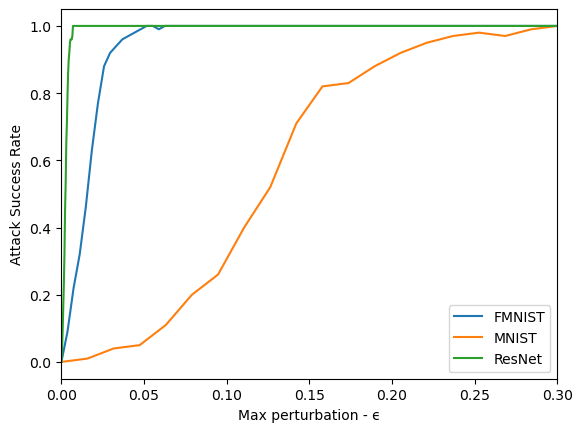

In [35]:
eps_df = pd.read_csv('Report/Results/eps_compare.tsv', sep='\t')
for ds in eps_df['DS'].unique():
    df = eps_df[eps_df['DS'] == ds]
    #df = df[df['eps'] <= 0.3]
    plt.plot(df['eps'], df['SR'], label=ds)
plt.xlim((0,0.3))
plt.legend()
plt.xlabel('Max perturbation - ϵ')
plt.ylabel('Attack Success Rate')
plt.savefig('Report/plots/eps_choice.png')
plt.show()


In [10]:
final_hist_dfs[1].groupby('stop_cond').size()

stop_cond
gap         30
max_iter    20
dtype: int64

In [19]:
final_hist.groupby('success')['gap_FW'].mean()

success
False    0.414841
True     0.106524
Name: gap_FW, dtype: float64

Mean FW iterations: 13.35


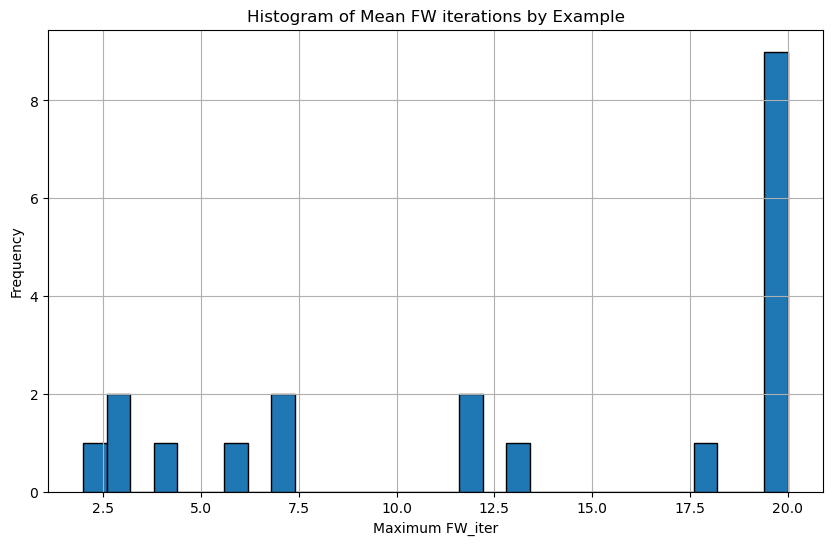

In [9]:
num_iters = hist_dfs[0].groupby('example_idx')['FW_iter'].max()
print(f"Mean FW iterations: {num_iters.mean()}")
plt.figure(figsize=(10, 6))
num_iters.plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Mean FW iterations by Example')
plt.xlabel('Maximum FW_iter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [40]:
final_hist['success'].mean()

0.89

In [41]:
final_hist['FW_iter'].mean()

8.42

In [31]:
# accuracy
hist.groupby('example_idx')['first_success'].sum().mean()

0.62

In [28]:
# average number of iterations for success
hist[hist['first_success']]['FW_iter'].mean()

1.0258064516129033

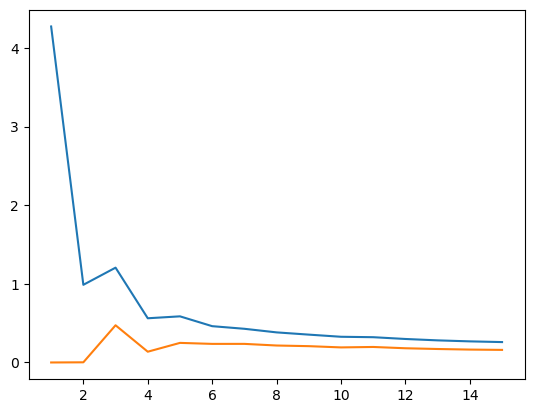

In [7]:
plt.plot(hist.groupby('FW_iter')['gap_FW'].mean())
plt.plot(hist.groupby('FW_iter')['gap_AS'].mean())

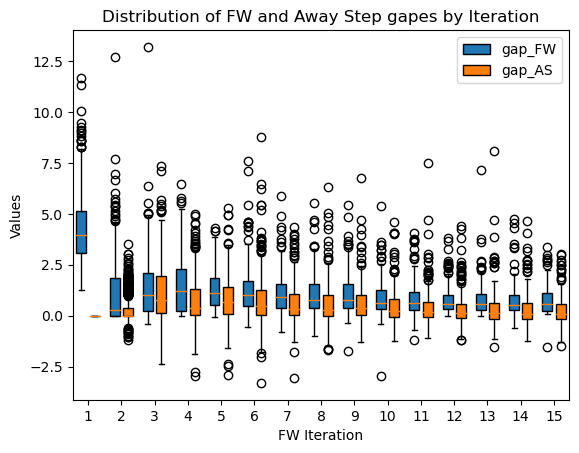

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data generation for demonstration purposes

# Extracting unique iteration groups
groups = hist['FW_iter'].unique()

# Creating lists to hold data for each group
data_FW = []
data_AS = []

for group in groups:
    data_FW.append(hist[hist['FW_iter'] == group]['gap_FW'].values)
    data_AS.append(hist[hist['FW_iter'] == group]['gap_AS'].values)

# Plotting
fig, ax = plt.subplots()

# Positions of the boxplots
positions_FW = np.arange(1, len(groups) + 1) * 2.0 - 0.4
positions_AS = np.arange(1, len(groups) + 1) * 2.0 + 0.4

# Creating the boxplots
box_FW = ax.boxplot(data_FW, positions=positions_FW, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C0"))
box_AS = ax.boxplot(data_AS, positions=positions_AS, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C1"))

# Customizing the plot
ax.set_xlabel('FW Iteration')
ax.set_ylabel('Values')
ax.set_title('Distribution of FW and Away Step gapes by Iteration')
ax.set_xticks(np.arange(1, len(groups) + 1) * 2.0)
ax.set_xticklabels([i for i in groups])

# Adding legend
ax.legend([box_FW["boxes"][0], box_AS["boxes"][0]], ['gap_FW', 'gap_AS'], loc='upper right')

# Display the plot
plt.show()


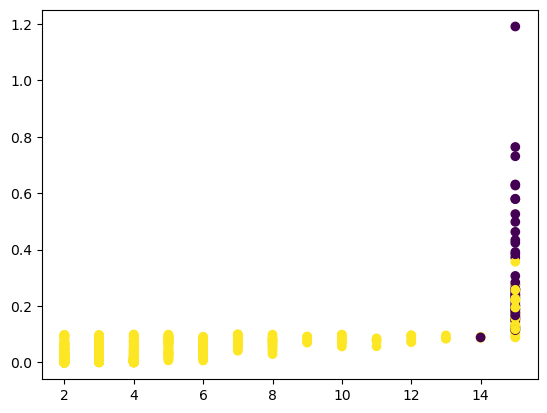

In [15]:
plt.scatter(final_hist['FW_iter'],final_hist['gap_FW'], c=final_hist['success'])

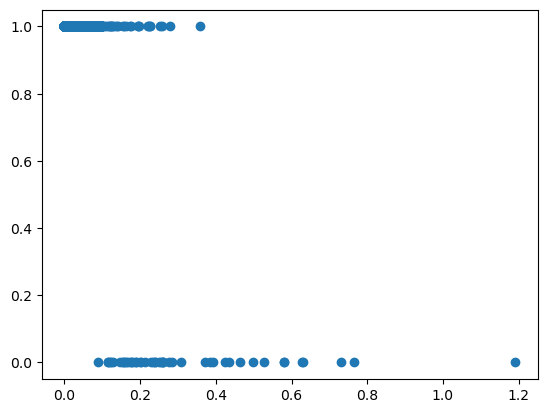

In [16]:
plt.scatter(final_hist['gap_FW'], final_hist['success'])

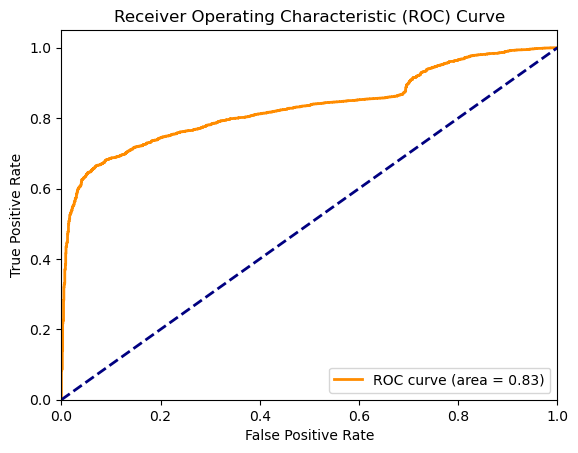

In [ ]:
from sklearn.metrics import roc_curve, auc

# Sample data: true binary labels and predicted probabilities
y_true = hist['success']
y_scores = 1- hist['gap_trans']

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

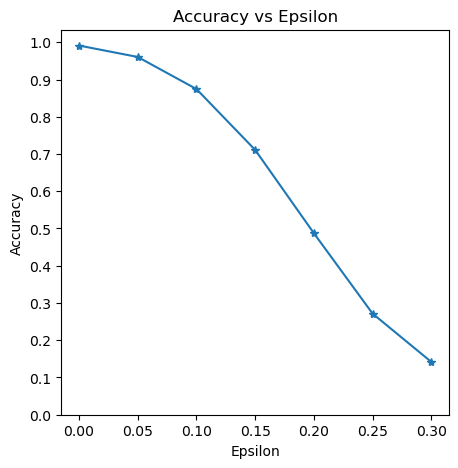

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

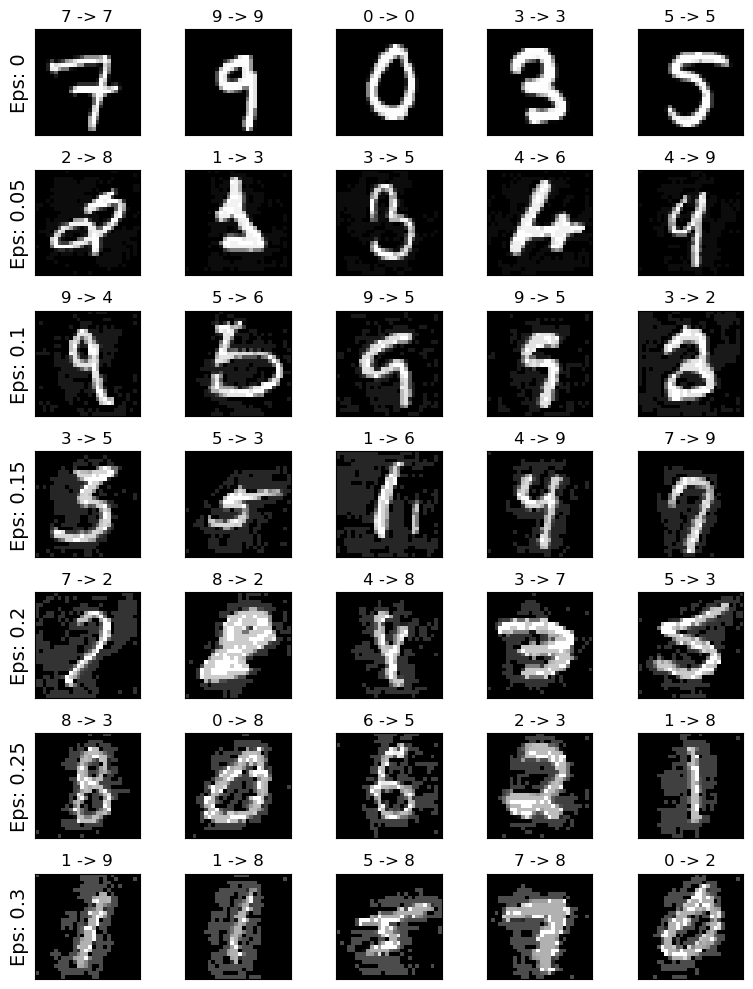

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()